### Импорт необходимых библиотек

In [1]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [111]:
from sklearn.metrics import confusion_matrix

### Классы для словаря, набора данных и получения векторных представлений

In [2]:
class Vocabulary(object):
    """Класс для создания словаря"""

    def __init__(self, token_to_idx=None):
        """
      Принимает необязательный аргумент token_to_idx, который является словарем, сопоставляющим токены с индексами. Если этот аргумент не передается, используется пустой словарь.
      Создает два атрибута:
      _token_to_idx: хранит сопоставление токенов с их индексами.
      _idx_to_token: хранит обратное сопоставление индексов с токенами, создается на основе _token_to_idx.
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}


    def add_token(self, token):
        """Добавляет токен в словарь, если его там еще нет, и возвращает его индекс.
        Если токен уже существует в _token_to_idx, просто возвращает его текущий индекс.
        Если токен новый, ему присваивается индекс, равный текущему размеру словаря _token_to_idx,
        после чего токен и его индекс добавляются в оба словаря, _token_to_idx и _idx_to_token.
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Принимает список токенов и добавляет их в словарь с помощью метода add_token.
        Возвращает список индексов, соответствующих добавленным токенам.
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Ищет индекс, соответствующий заданному токену, в _token_to_idx и возвращает его.
        Этот метод полезен, когда нужно узнать индекс токена для операций обработки или анализа текста.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Выполняет обратную операцию по сравнению с lookup_token: находит токен, соответствующий заданному индексу, в _idx_to_token.
        Если указанный индекс не существует в словаре, метод генерирует исключение KeyError.

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    """Класс для словаря последовательностей"""
    #unk_token ("<UNK>"): Токен для обозначения неизвестных слов, которые не встречаются в словаре. Это позволяет модели корректно обрабатывать слова, отсутствующие в обучающем датасете.
    #mask_token ("<MASK>"): Токен, используемый для "маскирования" некоторых элементов входной последовательности в процессе обучения, что может быть полезно для определенных видов задач, таких как предсказание следующего слова.
    #begin_seq_token ("<BEGIN>"): Токен, указывающий на начало последовательности. Это может быть полезно для задач, где модель должна знать, когда начинается новый ввод текста.
    #end_seq_token ("<END>"): Токен, обозначающий конец последовательности. Использование этого токена позволяет модели определить, когда ввод текста закончился.
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [4]:
class SurnameVectorizer(object):
    """ Класс для векторизации последовательностей """
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token)
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

In [12]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv('surnames.csv')
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))


    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]

        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index,
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size



def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### Модель

In [27]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifierRNN(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifierRNN, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = nn.RNN(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out, _ = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)


### Параметры модели

In [80]:
args = Namespace(
    # Data and path information
    surname_csv="surnames.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [23]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifierRNN(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

### Обучение базовой модели

In [14]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [49]:
# Инициализация словарей для сохранения истории точности
accuracy_history = {
    'RNN': {'train_acc': [], 'val_acc': []},
    'LSTM': {'train_acc': [], 'val_acc': []}
}

In [50]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    # Сохраняем результаты обучения в словарь accuracy_history для RNN
    accuracy_history['RNN']['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    accuracy_history['RNN']['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

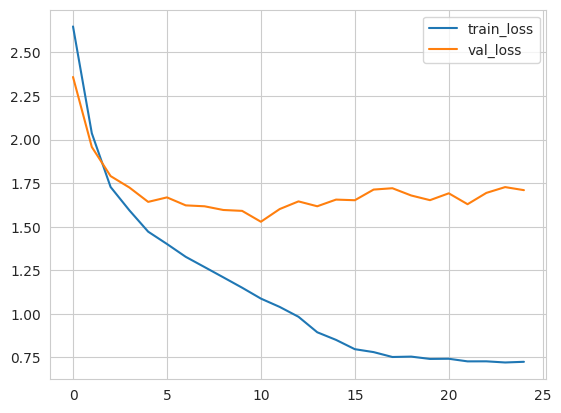

In [16]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

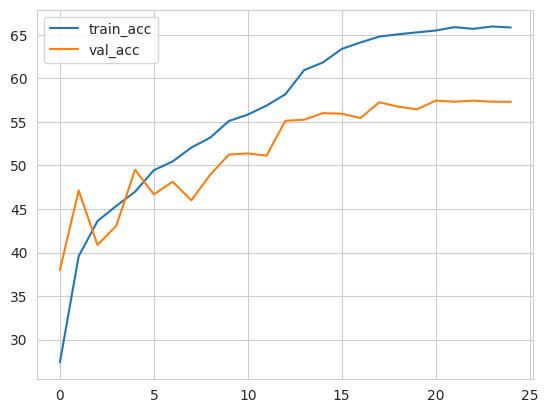

In [17]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

### Изменение архитектуры модели

Для проведения эксперимента переопределим класс SurnameClassifier (SurnameClassifierRNN в базовой модели) с изменённой архитектурой сети.

В качестве скрытого слоя инициализируем LSTM, оставив прочие скрытые слои без изменений.

In [67]:
# Инициализация словарей для сохранения истории точности
accuracy_history_lstm = {
    'LSTM_base': {'train_acc': [], 'val_acc': []},
    'LSTM_changed': {'train_acc': [], 'val_acc': []}
}

In [74]:
# Инициализация словарей для сохранения истории точности
cross_entropy = {
    'LSTM_CS': {'train_acc': [], 'val_acc': []},
    'LSTM_NO_CS': {'train_acc': [], 'val_acc': []}
}

In [64]:
def column_gather(y_out, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifierLSTM(nn.Module):
    """Классификатор с LSTM для извлечения признаков и MLP для классификации"""
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 lstm_hidden_size, batch_first=True, padding_idx=0):
        super(SurnameClassifierLSTM, self).__init__()
        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=lstm_hidden_size,
                            batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=lstm_hidden_size,
                             out_features=lstm_hidden_size)
        self.fc2 = nn.Linear(in_features=lstm_hidden_size,
                             out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        x_embedded = self.emb(x_in)
        y_out, _ = self.lstm(x_embedded)  # Игнорируем состояние ячейки

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [81]:

# параметры модели
args = Namespace(
    # Data and path information
    surname_csv="surnames.csv",
    # Model hyper parameter
    char_embedding_size=100,
    lstm_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)
# Проверка доступности CUDA
if args.cuda and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Добавление атрибута device в объект args
args.device = device

In [82]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifierLSTM(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [84]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    accuracy_history['LSTM']['train_acc'].append(running_acc)
    accuracy_history_lstm['LSTM_base']['train_acc'].append(running_acc)
    cross_entropy['LSTM_CS']['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    accuracy_history['LSTM']['val_acc'].append(running_acc)
    accuracy_history_lstm['LSTM_base']['val_acc'].append(running_acc)
    cross_entropy['LSTM_CS']['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

### Изменение гиперпараметров модели

Поскольку увеличение количества эпох не даст явных результатов (см. раздел "Сравнение моделей с разными архитектурами"), остановимся на изменении других гиперпараметров, а именно увеличении lstm_hidden_size с уменьшением количества эпох.

Такие изменения связаны с соображениями, по которым увеличение размерности скрытого слоя позволит лучше улавливать тонкости сочетания символов в фамилии.

In [69]:
# Параметры модели
args = Namespace(
    # Data and path information
    surname_csv="surnames.csv",
    # Model hyper parameter
    char_embedding_size=80,
    lstm_hidden_size=86,
    # Training hyper parameter
    num_epochs=20,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)
# Проверка доступности CUDA
if args.cuda and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Добавление атрибута device в объект args
args.device = device

In [70]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifierLSTM(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               lstm_hidden_size=args.lstm_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [71]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    accuracy_history_lstm['LSTM_changed']['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    accuracy_history_lstm['LSTM_changed']['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/20 [00:00<?, ?it/s]

### Сравнение LSTM-моделей с разными гиперпараметрами

Для иллюстрации зависимости качества классификации от количества эпох обучения, мы можем использовать данные из accuracy_history_lstm, которые содержат записи о точности на обучающем и валидационном наборах данных для каждой эпохи.


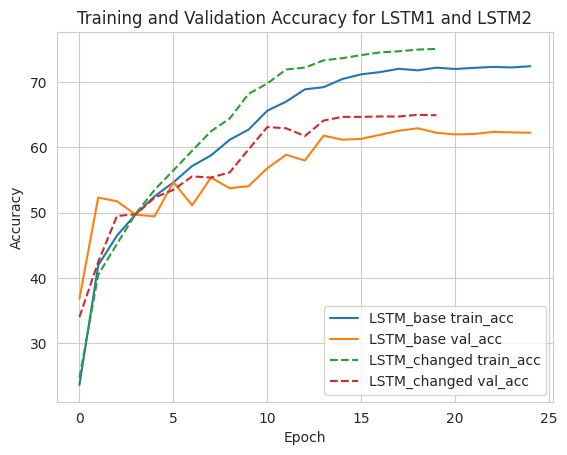

In [73]:
import matplotlib.pyplot as plt

# Определяем метки для графика
acc_labels = ["train_acc", "val_acc"]

# Визуализация результатов для RNN
for label in acc_labels:
    plt.plot(accuracy_history_lstm['LSTM_base'][label], label=f"LSTM_base {label}")

# Визуализация результатов для LSTM
for label in acc_labels:
    plt.plot(accuracy_history_lstm['LSTM_changed'][label], label=f"LSTM_changed {label}", linestyle='--')

plt.legend()
plt.title("Training and Validation Accuracy for LSTM1 and LSTM2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Увеличение параметра lstm_hidden_size, который определяет размер скрытого слоя в LSTM  модели, может привести к улучшению качества классификации по нескольким причинам:


*   Большая емкость модели: увеличение размера скрытого слоя позволяет модели иметь больше параметров (весов), что, в свою очередь, увеличивает ее емкость и способность выучивать более сложные зависимости в данных.

*   Улучшенное запоминание: LSTM разработаны для работы с долгосрочными зависимостями в последовательностях данных. Увеличение размера скрытого слоя улучшает способность модели запоминать и использовать информацию из далеких частей последовательности (начало фамилии).



### Сравнение моделей с разными архитектурами


Для иллюстрации зависимости качества классификации от количества эпох обучения, мы можем использовать данные из accuracy_history, которые содержат записи о точности на обучающем и валидационном наборах данных для каждой эпохи. Из этих данных можно попытаться выявить моменты, когда модель, возможно, недообучилась или переобучилась.

Недообучение модели обычно происходит на ранних этапах обучения, когда точность на обучающем наборе данных низкая, а модель ещё не адаптировалась к данным. Переобучение же проявляется в том, что точность на обучающем наборе данных продолжает расти или остается высокой, в то время как точность на валидационном наборе данных либо начинает снижаться, либо перестает расти, что указывает на ухудшение обобщающей способности модели.

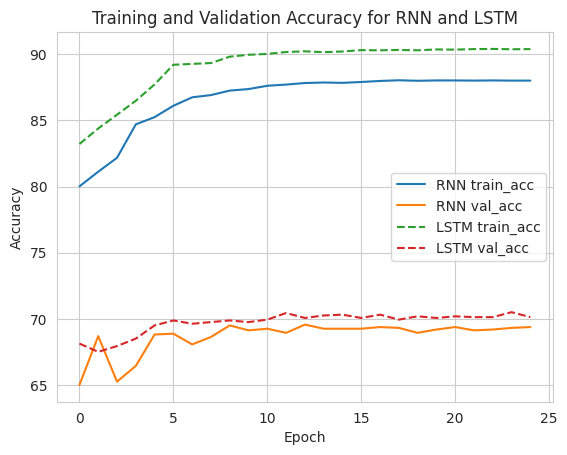

In [52]:
import matplotlib.pyplot as plt

# Определяем метки для графика
acc_labels = ["train_acc", "val_acc"]

# Визуализация результатов для RNN
for label in acc_labels:
    plt.plot(accuracy_history['RNN'][label], label=f"RNN {label}")

# Визуализация результатов для LSTM
for label in acc_labels:
    plt.plot(accuracy_history['LSTM'][label], label=f"LSTM {label}", linestyle='--')

plt.legend()
plt.title("Training and Validation Accuracy for RNN and LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Согласно графикам можно сделать вывод, что вне зависимости от архитектуры модели (RNN или LSTM) при количестве эпох от 1 до 5 модель ещё не адаптировалась к данным, что свидетельствует о недообучении.

LSTM: После 5 эпохи показатели точности на валидационной выборке свидетельствуют о переобучении, поскольку обобщаемость данных перестаёт расти.
RNN: Показатели на валидационной выборке отличаются изменчивостью поведения вплоть до 8 эпохи, после которой точность выходит на плато.

Таким образом переобучение для архитектуры LSTM наступает после 5 эпохи, а для архитектуры RNN после 8.

### Целевые метки в датасете

Для учета весов классов в функцию потерь CrossEntropyLoss передают аргумент с
соответствующими весами.
Оценим изменения точности при обучении при наличии/отсутствии аргумента
с весами классов.

In [90]:
classifier = classifier.to(args.device)

# Инициализация без аргумента
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    accuracy_history['LSTM']['train_acc'].append(running_acc)
    accuracy_history_lstm['LSTM_base']['train_acc'].append(running_acc)
    cross_entropy['LSTM_NO_CS']['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    accuracy_history['LSTM']['val_acc'].append(running_acc)
    accuracy_history_lstm['LSTM_base']['val_acc'].append(running_acc)
    cross_entropy['LSTM_NO_CS']['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

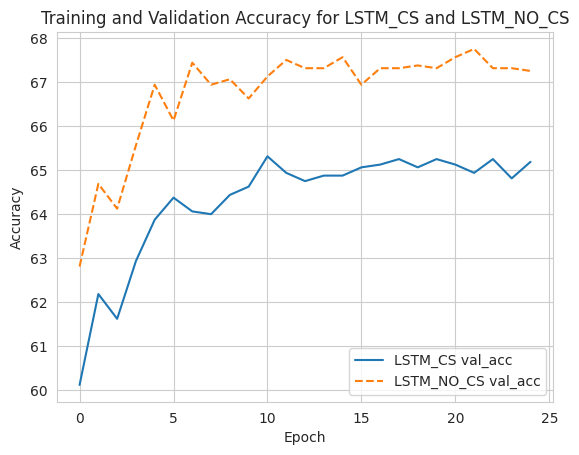

In [88]:

# Определяем метки для графика
acc_labels = ["val_acc"]

# Визуализация результатов для LSTM_CS
for label in acc_labels:
    plt.plot(cross_entropy['LSTM_CS'][label], label=f"LSTM_CS {label}")

# Визуализация результатов для LSTM_NO_CS
for label in acc_labels:
    plt.plot(cross_entropy['LSTM_NO_CS'][label], label=f"LSTM_NO_CS {label}", linestyle='--')

plt.legend()
plt.title("Training and Validation Accuracy for LSTM_CS and LSTM_NO_CS")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [91]:
df = pd.read_csv('surnames.csv')

In [92]:
df.nationality.value_counts()

English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: nationality, dtype: int64

In [95]:
df.head()

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train


Результаты показывают, что при отсутствии весов классов точность выше.


Без весов классов функция потерь обрабатывает все ошибки одинаково, что может привести к более низким общим потерям в начале, но на деле это может означать, что модель преимущественно адаптируется к более крупным классам.


Модель демонстрирует высокую общую точность за счет точности на доминирующих классах, но точность на меньших классах может быть низкой из-за несбалансированности в обучающих данных.

Можно предположить, что модель хорошо подстроилась под предсказание доминирующих классов (Английский, Русский, Арабский). Фамилий в доминирующих классах заметно больше, чем португальских или вьетнамских фамилий. Всвязи с этим и общие показатели точности растут, но в то же время на новых данных с корейскими, вьетнамскими и т.д. фамлиями модель будет выполнять предсказание хуже.

Использование весов может улучшить точность распознавания на меньших классах и повысить общую сбалансированную точность модели, так как модель лучше адаптируется к всем классам, а не только к доминирующим.

### Оценка модели

In [108]:
# Предположим, что df уже загружен и содержит колонки 'surname', 'nationality', 'split'
test_df = df[df['split'] == 'test'].reset_index(drop=True)

# Создаем векторизатор из обучающего набора данных (или весь набор данных, если таковой способ вам подходит)
vectorizer = SurnameVectorizer.from_dataframe(df[df['split'] == 'train'])

In [109]:
y_true = []
y_pred = []

# Перевод модели в режим оценки
classifier.eval()

with torch.no_grad():
    for index, row in test_df.iterrows():
        vectorized_surname, vec_length = vectorizer.vectorize(row.surname)
        # Преобразование в тензор и добавление размерности batch
        vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0).to(args.device)
        vec_length = torch.tensor([vec_length], dtype=torch.int64).to(args.device)

        # Получение предсказания
        prediction = classifier(x_in=vectorized_surname, x_lengths=vec_length)
        prediction = prediction.max(dim=1)[1].item()  # Получаем индекс максимального значения

        # Добавление истинной метки и предсказания в списки
        y_true.append(vectorizer.nationality_vocab.lookup_token(row.nationality))
        y_pred.append(prediction)


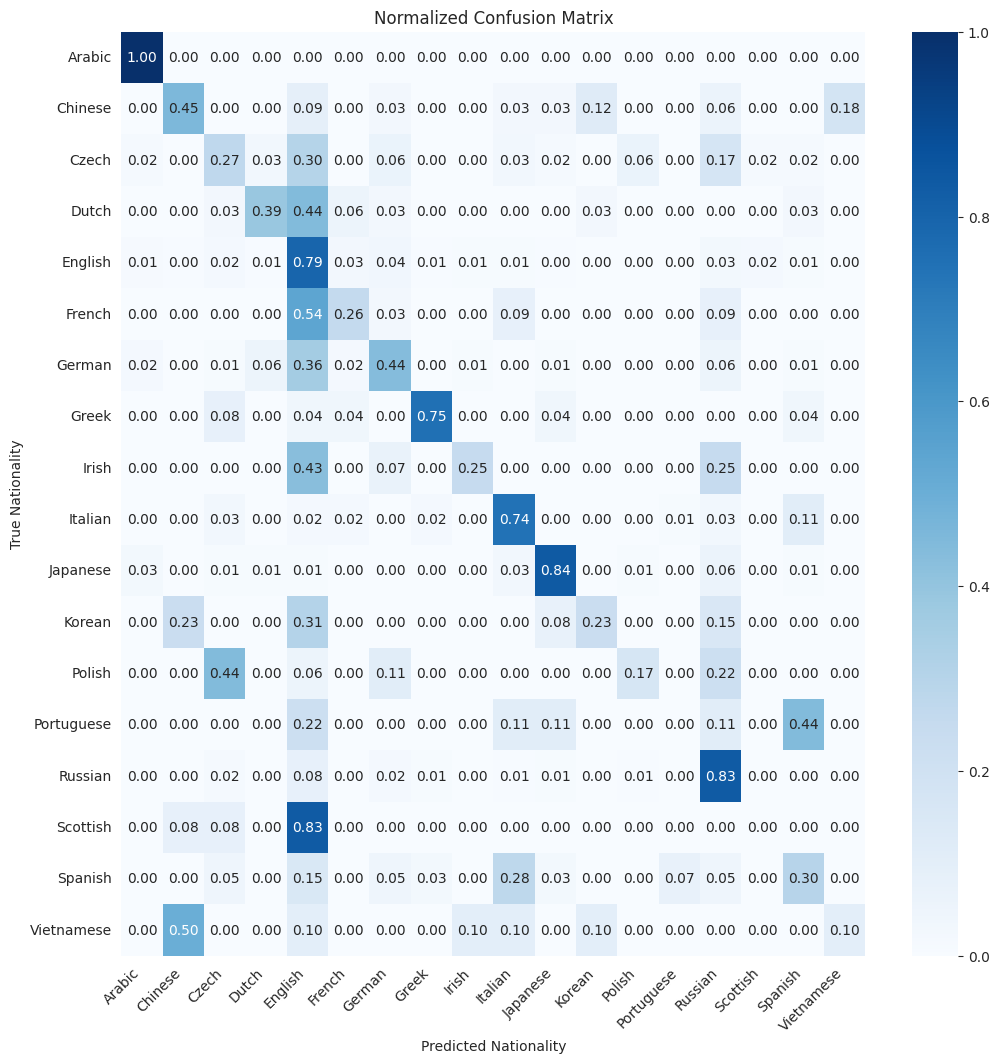

In [112]:
# Создание confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Нормализация confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Визуализация
plt.figure(figsize=(12, 12))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=vectorizer.nationality_vocab._token_to_idx.keys(),
            yticklabels=vectorizer.nationality_vocab._token_to_idx.keys())
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Nationality")
plt.xlabel("Predicted Nationality")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

Лучше всего определяемые национальности видны по высоким значениям на главной диагонали матрицы. Высокие значения указывают на то, что модель успешно определяет большинство образцов этих национальностей.

Группы национальностей с частыми ошибками видны по высоким значениям вне главной диагонали. Это указывает на то, что модель часто путает эти национальности друг с другом.

Лучше всего модель справляется с определением доминирующих классов (Арабские, английские, русские).



1.   Чаще всего модель ошибается на шотландских фамилиях, причём происходит это из-за спутывания с английскими фамилиями. Это можно связать с тем, что регионы располагаются по соседству и обладают схожими типовыми фамилиями. Причём шотландские фамилии представлены 75 фамлиями, в то время как английские 2972. Из-за схожести фамилий класс английских доминирует над шотландскими.
2.   Аналогичным образом можно описать ошибки для вьетнамских фамилий с китайскими. Такая же картина для польских и чешских фамилий.
3.   Неожиданно (исходя из наполненности классов) выполняется предсказание для японских фамилий (лучше, чем для английских). Это может быть связано с исключетильными особенностями правописания японских фамилий (см. ячейку ниже).
4.  Для классов, представленных малым количеством фамилий (напр. португальские) модель не делает правильных предсказаний вовсе. Это связано с тем, что португальские фамилии представлены крайне малым объёмом. Модель принимает такие фамилии за испанские (из-за близости регионов и бОльшим количеством последних).

Общие выводы:


1.   Наиболее частая причина путаницы между национальностями заключается в схожести фамилий, которые могут иметь общие корни или используемые символы (регионально или исторически связанные страны)
2.   Если определенные национальности представлены в обучающем наборе данных недостаточно, модель может не научиться адекватно их распознавать, что приводит к ошибкам.
3. Большое внутриклассовое разнообразие также может усложнить задачу классификации для модели, особенно если фамилии одной национальности могут принадлежать к различным культурным или языковым группам (напр. английские фамилии).




In [113]:
df[df['nationality'] == 'Japanese']

,surname,nationality,split
7189,Tagawa,Japanese,train
7190,Okuda,Japanese,train
7191,Hokusai,Japanese,train
7192,Nozaki,Japanese,train
7193,Yasuhiro,Japanese,train
...,...,...,...
7959,Fugunaga,Japanese,test
7960,Ryusaki,Japanese,test
7961,Tenshin,Japanese,test
7962,Shimazu,Japanese,test
